In [14]:
import torch

def neck_angle_score(neck_angle, steepness=10.0):
    """
    Calculate a fully differentiable REBA neck score based on the angle of the neck using PyTorch.
    
    Parameters:
        neck_angle (torch.Tensor): The neck angle in degrees. Can be a single value or a tensor of values.
        steepness (float): The steepness of the sigmoid transitions.
    
    Returns:
        torch.Tensor: Differentiable REBA score(s).
    """
    # Define thresholds
    low_threshold = 0.0
    high_threshold = 20.0

    # Smooth transition for each range using sigmoid
    low_range = torch.sigmoid(-steepness * neck_angle)  # Below 0
    high_range = torch.sigmoid(steepness * (neck_angle - high_threshold))  # Above 20

    # Weighted sum to ensure smoothness
    score = 1 + low_range + high_range
    return score

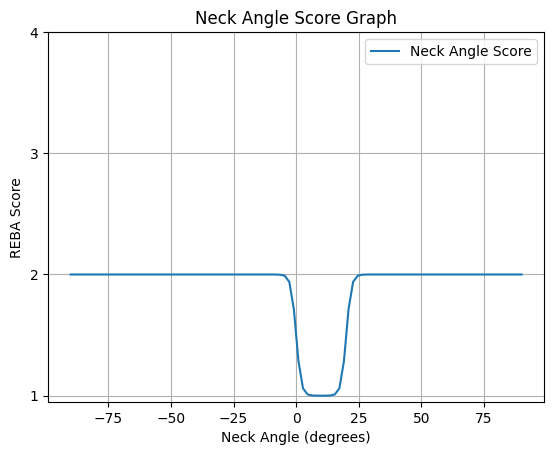

In [23]:
import matplotlib.pyplot as plt

# Generate sample neck angles
neck_angles = torch.linspace(-90, 90, steps=100)

# Calculate neck angle scores
scores = neck_angle_score(neck_angles, steepness=1)

# Plot the neck angle scores
plt.plot(neck_angles.numpy(), scores.numpy(), label='Neck Angle Score')
plt.xlabel('Neck Angle (degrees)')
plt.ylabel('REBA Score')
plt.yticks([1, 2, 3, 4])
plt.title('Neck Angle Score Graph')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def trunk_angle_score(trunk_angle, steepness=10.0):
    """
    Calculate a fully differentiable REBA trunk score based on the trunk angle using PyTorch.
    
    Parameters:
        trunk_angle (torch.Tensor): The trunk angle in degrees. Can be a single value or a tensor of values.
        steepness (float): The steepness of the sigmoid transitions.
    
    Returns:
        torch.Tensor: Differentiable REBA score(s).
    """
    # Define thresholds
    low_threshold_1 = -20.0
    high_threshold_1 = 20.0
    high_threshold_2 = 60.0

    # Smooth transition for each range using sigmoid
    below_low = torch.sigmoid(-steepness * (trunk_angle - low_threshold_1))  # Smooth transition below -20
    in_low_range = torch.sigmoid(steepness * (trunk_angle - low_threshold_1)) * (1 - torch.sigmoid(steepness * (trunk_angle - high_threshold_1)))  # -20 to 20
    in_mid_range = torch.sigmoid(steepness * (trunk_angle - high_threshold_1)) * (1 - torch.sigmoid(steepness * (trunk_angle - high_threshold_2)))  # 20 to 60
    above_high = torch.sigmoid(steepness * (trunk_angle - high_threshold_2))  # Smooth transition above 60

    # Combine scores
    score = 1 + below_low * 2 + in_low_range * 1 + in_mid_range * 2 + above_high * 3

    return score

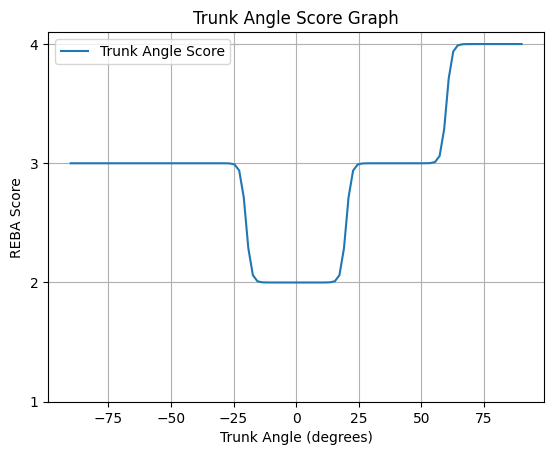

In [24]:
# Generate sample angles
angles = torch.linspace(-90, 90, steps=100)

# Calculate neck angle scores
scores = trunk_angle_score(angles, steepness=1)

# Plot the neck angle scores
plt.plot(angles.numpy(), scores.numpy(), label='Trunk Angle Score')
plt.xlabel('Trunk Angle (degrees)')
plt.ylabel('REBA Score')
plt.title('Trunk Angle Score Graph')
plt.yticks([1, 2, 3, 4])
plt.legend()
plt.grid(True)
plt.show()

In [27]:
def leg_angle_score(knee_angle, foot_lifted=0, steepness=10.0):
    """
    Calculate a differentiable REBA leg score based on the knee angle and foot lifted status using PyTorch.
    
    Parameters:
        knee_angle (torch.Tensor): The knee angle in degrees. Can be a single value or a tensor of values.
        foot_lifted (torch.Tensor): Binary tensor (0 or 1), where 1 indicates the foot is lifted.
        steepness (float): The steepness of the sigmoid transitions.
    
    Returns:
        torch.Tensor: Differentiable REBA score(s).
    """
    # Define knee angle thresholds
    low_threshold = 30.0
    high_threshold = 60.0

    # Smooth transition for each knee angle range
    in_mid_range = torch.sigmoid(steepness * (knee_angle - low_threshold)) * (1 - torch.sigmoid(steepness * (knee_angle - high_threshold)))  # 30 <= knee_angle <= 60
    above_high = torch.sigmoid(steepness * (knee_angle - high_threshold))  # knee_angle > 60

    # Foot lifted contributes 2 if lifted, 1 if not
    foot_score = 1 + foot_lifted  # 1 if not lifted, 2 if lifted

    # Base score
    score = foot_score + in_mid_range + 2 * above_high

    return score

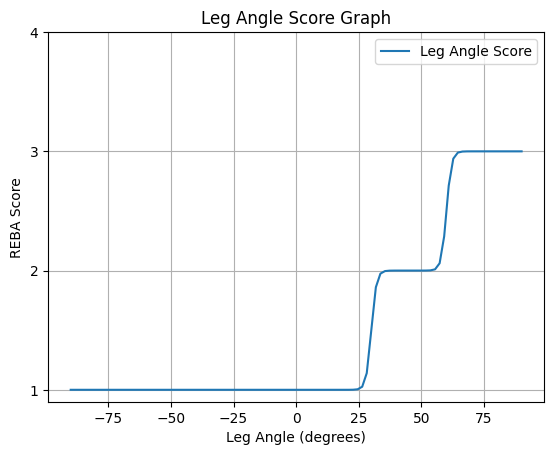

In [28]:
# Generate sample angles
angles = torch.linspace(-90, 90, steps=100)

# Calculate neck angle scores
scores = leg_angle_score(angles, steepness=1)

# Plot the neck angle scores
plt.plot(angles.numpy(), scores.numpy(), label='Leg Angle Score')
plt.xlabel('Leg Angle (degrees)')
plt.ylabel('REBA Score')
plt.title('Leg Angle Score Graph')
plt.yticks([1, 2, 3, 4])
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch

def score_a(neck, leg, trunk, steepness=10.0):
    """
    Calculate a differentiable Score A based on Neck, Leg, and Trunk floating scores using PyTorch.
    
    Parameters:
        neck (torch.Tensor): Neck floating scores.
        leg (torch.Tensor): Leg floating scores.
        trunk (torch.Tensor): Trunk floating scores.
        steepness (float): The steepness of the sigmoid transitions.
    
    Returns:
        torch.Tensor: Differentiable Score A.
    """
    table_coordinates = [
        [1, 1, 1, 1],
        [1, 1, 2, 2],
        [1, 1, 3, 2],
        [1, 1, 4, 3],
        [1, 1, 5, 4],
        [1, 2, 1, 2],
        [1, 2, 2, 3],
        [1, 2, 3, 4],
        [1, 2, 4, 5],
    ]
    # Table A: Define the Score Tensor (Neck x Legs x Trunk)
    score_table = torch.tensor([
        [[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8]],  # Neck 1
        [[2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9]],  # Neck 2
        [[3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 9]],  # Neck 3
    ], dtype=torch.float32)  # Shape: (3, 5, 4)

    # Soft assignments for Neck, Leg, Trunk
    neck_weights = torch.sigmoid(steepness * (neck.unsqueeze(0) - torch.arange(1, 4).view(-1, 1)))  # (3, 1)
    leg_weights = torch.sigmoid(steepness * (leg.unsqueeze(0) - torch.arange(1, 6).view(-1, 1)))    # (5, 1)
    trunk_weights = torch.sigmoid(steepness * (trunk.unsqueeze(0) - torch.arange(1, 6).view(-1, 1))) # (5, 1)

    # Normalize weights
    neck_weights = neck_weights / neck_weights.sum(dim=0, keepdim=True)  # (3, 1)
    leg_weights = leg_weights / leg_weights.sum(dim=0, keepdim=True)    # (5, 1)
    trunk_weights = trunk_weights / trunk_weights.sum(dim=0, keepdim=True)  # (5, 1)

    # Apply Neck weights to Score Table
    neck_applied = torch.einsum("ijk,i->jk", score_table, neck_weights.squeeze())  # Shape: (5, 4)

    # Apply Leg weights
    leg_applied = torch.einsum("jk,j->k", neck_applied, leg_weights.squeeze())  # Shape: (4,)

    # Apply Trunk weights
    trunk_applied = torch.einsum("k,k->", leg_applied, trunk_weights.squeeze())  # Shape: ()

    return trunk_applied


In [35]:
# Import torch if not already imported
import torch

# Example input values with requires_grad=True to enable gradient tracking
neck = torch.tensor([1.2], requires_grad=True)  # Neck value between 1 and 2
leg = torch.tensor([3.0], requires_grad=True)   # Leg value in category 3
trunk = torch.tensor([3.8], requires_grad=True) # Trunk value between 4 and 5

# Calculate Score A
score = score_a(neck, leg, trunk)

# Perform backward pass to compute gradients
score.backward()

# Print gradients
print("Gradient w.r.t Neck:", neck.grad)
print("Gradient w.r.t Leg:", leg.grad)
print("Gradient w.r.t Trunk:", trunk.grad)


RuntimeError: einsum(): subscript k has size 5 for operand 1 which does not broadcast with previously seen size 4